In [8]:
import mysql.connector
from mysql.connector import Error

def connect_to_mysql():
    try:
        connection = mysql.connector.connect(
            host='localhost',
            user='root',
            password='root123!',
            database='commerce'
        )

        if connection.is_connected():
            print('Successful connection to MySQL')
            cursor = connection.cursor()
            
            cursor.execute('SHOW TABLES')
            tables = cursor.fetchall()
            print('List of tables:', tables)
            
            cursor.close()
            connection.close()
            print('Connection closed')

    except Error as e:
        print(f'Error connecting to MySQL: {e}')

connect_to_mysql()

Successful connection to MySQL
List of tables: [('card_status',), ('companies',), ('credit_cards',), ('products',), ('transaction_items',), ('transactions',), ('users',)]
Connection closed


In [14]:
import mysql.connector
import pandas as pd

connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root123!',
    database='commerce'
)

query = '''
SELECT amount FROM transactions
WHERE declined = 0;
'''

transactions_df = pd.read_sql(query, connection)

connection.close()

print(transactions_df.head())

   amount
0  466.92
1   49.53
2   92.61
3  394.18
4  279.93


/var/folders/v_/gk51vt417q9d6n5mw6_phw500000gn/T/ipykernel_29928/1860515595.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  transactions_df = pd.read_sql(query, connection)


In [15]:
# описательная статистика
stats = transactions_df['amount'].describe()
print(round(stats, 2))

count    500.00
mean     259.01
std      143.14
min       15.05
25%      136.19
50%      262.47
75%      390.85
max      499.23
Name: amount, dtype: float64


In [19]:
total_amount = transactions_df['amount'].sum()
print(f'Total Sales Sum: {round(total_amount, 2)}')

Total Sales Sum: 129505.59


In [20]:
mode = transactions_df['amount'].mode()[0]
print(f'Mode: {mode}')

Mode: 171.43


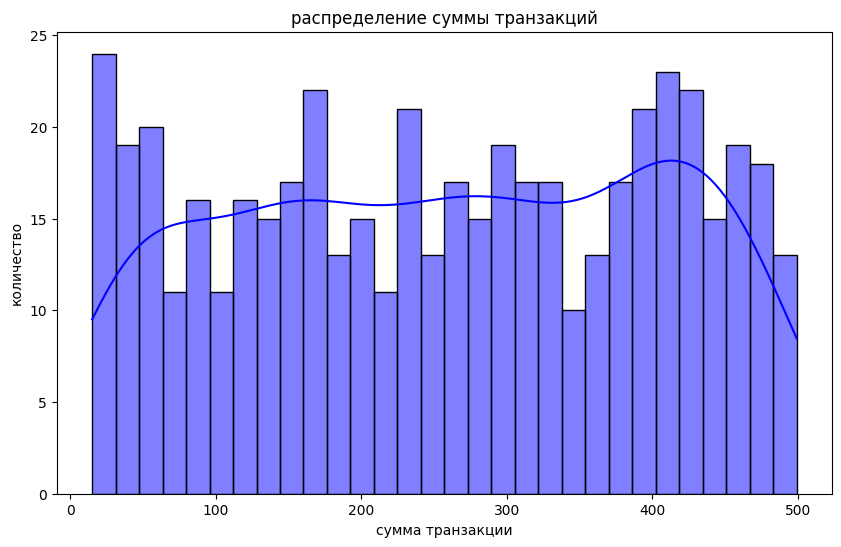

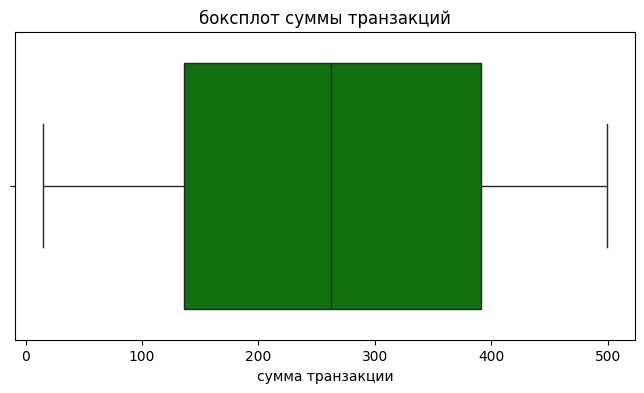

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# гистограмма
plt.figure(figsize=(10, 6))
sns.histplot(transactions_df['amount'], kde=True, bins=30, color='blue')
plt.title('распределение суммы транзакций')
plt.xlabel('cумма транзакции')
plt.ylabel('количество')
plt.show()

# боксплот
plt.figure(figsize=(8, 4))
sns.boxplot(x=transactions_df['amount'], color='green')
plt.title('боксплот суммы транзакций')
plt.xlabel('сумма транзакции')
plt.show()